In [1]:
import sys
sys.path.append('/volatile/Lena/Codes/Modèles/fastmri_tf_vs_torch/fastmri_compare/autre')

import os.path as op
import time
from matplotlib import pyplot as plt

from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow_addons.callbacks import TQDMProgressBar

from fastmri_tf.data.sequences.oasis_sequences import ZeroFilled2DSequence
from fastmri_tf.models.functional_models.unet import unet

In [2]:
# paths
train_path = '/volatile'

In [3]:
# generators
AF = 4
train_gen = ZeroFilled2DSequence(
    train_path,
    af=AF,
    inner_slices=32,
    scale_factor=1e-2,
    seed=0,
    rand=False,
    val_split=0.1,
    n_pooling=3,
)
val_gen = train_gen.val_sequence
n_train = 2 #1000
n_val = 200

run_params = {
    'n_layers': 4,
    'pool': 'max',
    "layers_n_channels": [16, 32, 64, 128],
    'layers_n_non_lins': 2,
}
n_epochs = 3 #300
run_id = f'unet_af{AF}_oasis_{int(time.time())}'
chkpt_path = f'checkpoints/{run_id}' + '-{epoch:02d}.hdf5'
print(run_id)

unet_af4_oasis_1710940141


In [5]:
print(train_gen.path)
print(train_gen.mode)
print(train_gen.af)
print(train_gen.reorder)
print(train_gen.filenames)
print(train_gen.val_sequence)

print(train_gen[0][1].shape)

/volatile
training
4
True
['/volatile/sub-OAS30001_ses-d0129_run-01_T1w.nii.gz']


(32, 256, 256, 1)


/volatile/Lena/Codes/Modèles/fastmri_tf_vs_torch/fastmri_compare/autre/fastmri_tf/data/sequences/oasis_sequences.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
  images_scaled = images_scaled.astype(np.float32)


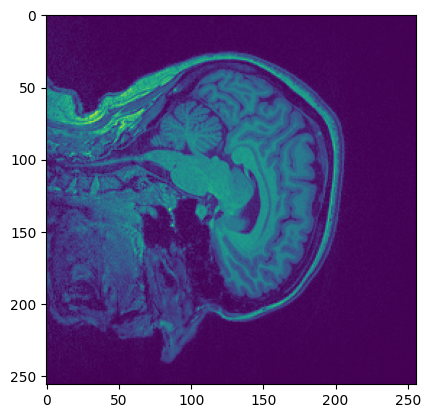

In [6]:
from matplotlib import pyplot as plt

plt.imshow(train_gen[0][1][8])

In [7]:
chkpt_cback = ModelCheckpoint(chkpt_path, save_freq=100)
log_dir = op.join('logs', run_id)
tboard_cback = TensorBoard(
    profile_batch=0,
    log_dir=log_dir,
    histogram_freq=0,
    write_graph=True,
    write_images=False,
)
tqdm_cb = TQDMProgressBar()


/volatile/Lena/Environments/fastmri/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
model = unet(input_size=(None, None, 1), lr=1e-3, **run_params)
print(model.summary())

2024-03-20 14:09:03.716340: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2024-03-20 14:09:03.716396: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-03-20 14:09:03.717305: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/volatile/Lena/Environments/fastmri/lib/py

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   160         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, None, None,   2320        ['conv2d[0][0]']                 
                                16)                                                            

In [10]:

model.fit(
    train_gen,
    steps_per_epoch=n_train,
    epochs=n_epochs,
    validation_data=val_gen,
    validation_steps=1,
    verbose=1,
    callbacks=[tqdm_cb, tboard_cback, chkpt_cback],
    # max_queue_size=100,
    use_multiprocessing=True,
    workers=35,
)


/volatile/Lena/Codes/Modèles/fastmri_tf_vs_torch/fastmri_compare/autre/fastmri_tf/data/sequences/oasis_sequences.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
  images_scaled = images_scaled.astype(np.float32)
Training:   0%|           0/3 ETA: ?s,  ?epochs/s

Epoch 1/3


Epoch 1/3


1/2 [==============>...............] - ETA: 11s - loss: 0.7608 - mean_squared_error: 1.4559 - keras_psnr: 16.3304 - keras_ssim: 0.3640

2/2 [==============================] - ETA: 0s - loss: 0.7587 - mean_squared_error: 1.4505 - keras_psnr: 16.3467 - keras_ssim: 0.3704 

2/2██████████ ETA: 00:00s - loss: 0.7587 - mean_squared_error: 1.4505 - keras_psnr: 16.3467 - keras_ssim: 0.3704
Training:  33%|███▎       1/3 ETA: 00:37s,  18.91s/epochs

2/2 [==============================] - 19s 7s/step - loss: 0.7587 - mean_squared_error: 1.4505 - keras_psnr: 16.3467 - keras_ssim: 0.3704
Epoch 2/3


Epoch 2/3


1/2 [==============>...............] - ETA: 9s - loss: 0.7522 - mean_squared_error: 1.4339 - keras_psnr: 16.3968 - keras_ssim: 0.3892

2/2 [==============================] - ETA: 0s - loss: 0.7502 - mean_squared_error: 1.4282 - keras_psnr: 16.4139 - keras_ssim: 0.3930

2/2██████████ ETA: 00:00s - loss: 0.7502 - mean_squared_error: 1.4282 - keras_psnr: 16.4139 - keras_ssim: 0.3930
Training:  67%|██████▋    2/3 ETA: 00:17s,  17.87s/epochs

2/2 [==============================] - 17s 8s/step - loss: 0.7502 - mean_squared_error: 1.4282 - keras_psnr: 16.4139 - keras_ssim: 0.3930
Epoch 3/3


Epoch 3/3


1/2 [==============>...............] - ETA: 10s - loss: 0.7441 - mean_squared_error: 1.4124 - keras_psnr: 16.4622 - keras_ssim: 0.4064

2/2 [==============================] - ETA: 0s - loss: 0.7420 - mean_squared_error: 1.4070 - keras_psnr: 16.4791 - keras_ssim: 0.4114 

2/2██████████ ETA: 00:00s - loss: 0.7420 - mean_squared_error: 1.4070 - keras_psnr: 16.4791 - keras_ssim: 0.4114
Training: 100%|██████████ 3/3 ETA: 00:00s,  18.16s/epochs

2/2 [==============================] - 18s 8s/step - loss: 0.7420 - mean_squared_error: 1.4070 - keras_psnr: 16.4791 - keras_ssim: 0.4114


Training: 100%|██████████ 3/3 ETA: 00:00s,  18.28s/epochs


In [14]:
outputs = model.predict(train_gen)
outputs.shape

/volatile/Lena/Codes/Modèles/fastmri_tf_vs_torch/fastmri_compare/autre/fastmri_tf/data/sequences/oasis_sequences.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
  images_scaled = images_scaled.astype(np.float32)


(32, 256, 256, 1)

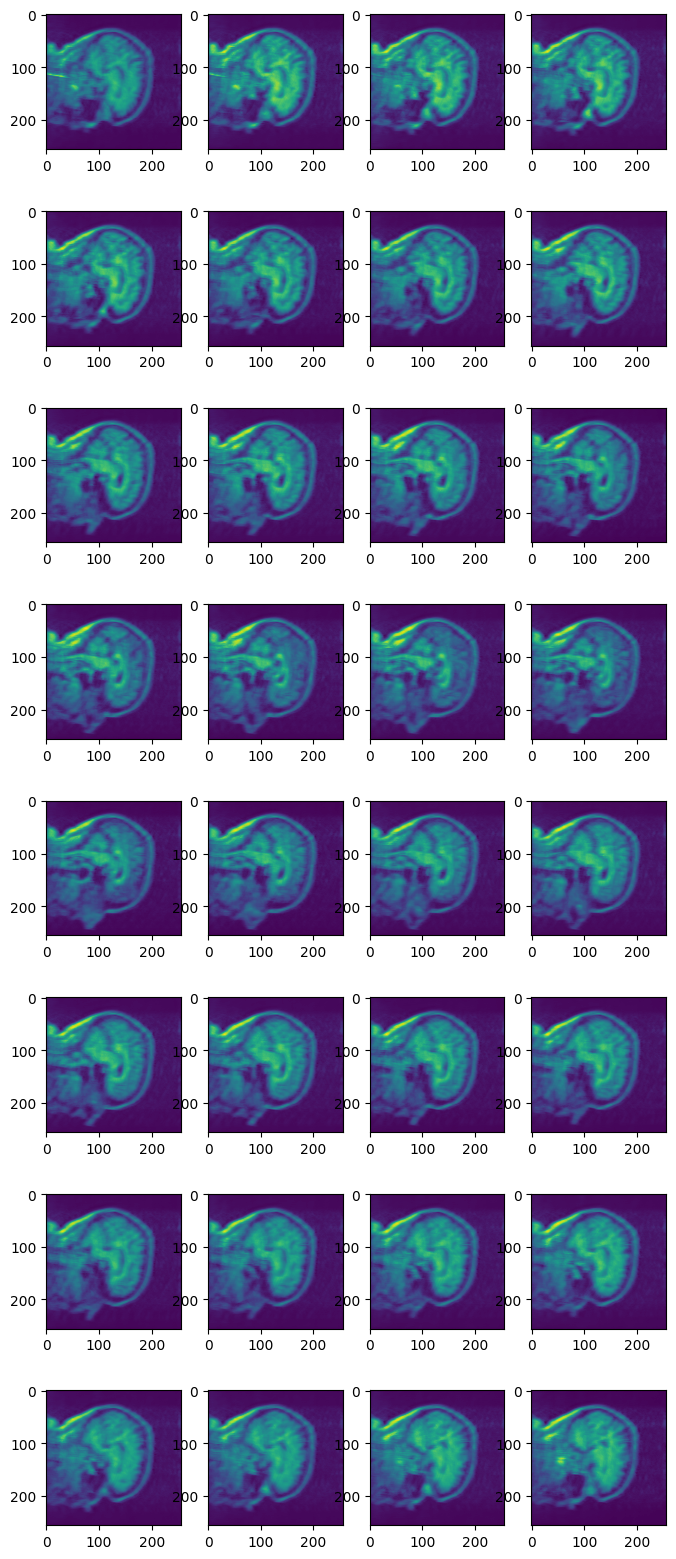

In [15]:
plt.figure(figsize=(8,20))
for i in range(outputs.shape[0]):
    plt.subplot(8,4,i+1)
    plt.imshow(outputs[i,:,:,0])
